In [2]:
from scipy.io import wavfile
import numpy as np
from librosa import pyin, note_to_hz
import pandas as pd
from scipy.stats import mode, skew, kurtosis
from scipy.fft import rfft, rfftfreq


In [3]:
def get_fund_freqs(data, sample_rate):
    freq0, voiced_flag, voiced_probs = pyin(
        y=data, 
        fmin=note_to_hz('C2'), 
        fmax=note_to_hz('C7'), 
        sr=sample_rate, 
        frame_length=2048
    )

    freq0 = freq0[voiced_flag]
    freq0 = np.array(freq0[freq0 > 0])
    freq0 /= 1000
    return freq0

In [4]:
def calc_quantile(data, quantile):
    return np.percentile(data, quantile)

In [5]:
def calculate_frame_dominant_frequency(data, sample_rate):
    # Apply FFT and get frequency bins
    fft_result = rfft(data)
    frequencies = rfftfreq(len(data), 1/sample_rate)
    magnitude = np.abs(fft_result)
    # Find the dominant frequency in the frame
    dominant_frequency = frequencies[np.argmax(magnitude)]
    return dominant_frequency

def calculate_dominant_frequencies(data, sample_rate, frame_size_ms=40, hop_size_ms=20):
    # Read the WAV file
    #data, sample_rate = librosa.load(wav_file)
    # If stereo, just use one channel
    if len(data.shape) > 1:
        data = data[:, 0]
    
    # Convert frame size and hop size from milliseconds to samples
    frame_size = int(sample_rate * (frame_size_ms / 1000.0))
    hop_size = int(sample_rate * (hop_size_ms / 1000.0))
    
    # Apply a windowing function to each frame (e.g., Hamming window)
    window = np.hamming(frame_size)
    
    # Initialize an array to hold the dominant frequencies for each frame
    dominant_frequencies = []
    
    # Process each frame of the audio
    for start in range(0, len(data) - frame_size + 1, hop_size):
        frame = data[start:start+frame_size] * window
        dominant_frequency = calculate_frame_dominant_frequency(frame, sample_rate)
        dominant_frequencies.append(dominant_frequency)
    
    # Filter out very low frequencies (e.g., below 20 Hz) to exclude DC component or noise
    dominant_frequencies = [freq for freq in dominant_frequencies if freq >= 20]
    
    # Calculate statistics
    mean_dom_freq = np.mean(dominant_frequencies)/1000
    min_dom_freq = np.min(dominant_frequencies)/1000
    max_dom_freq = np.max(dominant_frequencies)/1000
    
    return mean_dom_freq, min_dom_freq, max_dom_freq


In [11]:
import pydub
def extract_audio_features(wave_file_path):
    features = {
        'meanfreq': 0.0,
        # 'sd': 0.0,
        'median': 0.0,
        'Q25': 0.0,
        'Q75': 0.0,
        'IQR': 0.0,
        'skew': 0.0,
        'kurt': 0.0,
        # 'sp.ent': 0.0,
        # 'sfm': 0.0,
        'mode': 0.0,
        # 'centroid': 0.0,
        # 'meanfun': 0.0,
        # 'minfun': 0.0,
        # 'maxfun': 0.0,
        'meandom': 0.0,
        'mindom': 0.0,
        'maxdom': 0.0,
        # 'dfrange': 0.0,
        # 'modindx': 0.0
    }

    sample_rate, data = wavfile.read(wave_file_path)
    print(data)

    data = np.float64(data)
    freqs0 = get_fund_freqs(data, sample_rate)
    mean_freqs0 = np.mean(freqs0)
    median_freqs0 = np.median(freqs0)
    mode_freqs0 = mode(freqs0)[0]

    first_quant = calc_quantile(freqs0, 25)
    third_quant = calc_quantile(freqs0, 75)
    inter_quant_range = third_quant - first_quant

    skewness = skew(data)
    kurtos = kurtosis(data)

    mean_dom_freq, min_dom_freq, max_dom_freq = calculate_dominant_frequencies(data, sample_rate)

    features['meanfreq'] = mean_freqs0
    features['median'] = median_freqs0
    features['Q25'] = first_quant
    features['Q75'] = third_quant
    features['IQR'] = inter_quant_range
    features['skew'] = skewness
    features['kurt'] = kurtos
    features['mode'] = mode_freqs0
    features['meandom'] = mean_dom_freq
    features['mindom'] = min_dom_freq
    features['maxdom'] = max_dom_freq
    
    return features

In [12]:
features = extract_audio_features('output.wav')


print("Extracted Features")
print("================================================")
print("{0:<10}".format("Feature") + " | Value")
print("-----------+------------------------------------")
for feature in features.keys():
    print(f"{feature:<10} | {features[feature]}".format())
print("================================================")

print(features.values())


[ 80  85  94 ... 188 187 197]
Extracted Features
Feature    | Value
-----------+------------------------------------
meanfreq   | 0.08695700051732963
median     | 0.08883315834800462
Q25        | 0.08288426748110167
Q75        | 0.09090953499696329
IQR        | 0.00802526751586162
skew       | -0.35311119514592687
kurt       | 6.9985289161830675
mode       | 0.09143616857570666
meandom    | 0.2175
mindom     | 0.025
maxdom     | 0.7
dict_values([0.08695700051732963, 0.08883315834800462, 0.08288426748110167, 0.09090953499696329, 0.00802526751586162, -0.35311119514592687, 6.9985289161830675, 0.09143616857570666, 0.2175, 0.025, 0.7])


In the dataset, there are...
	3168       data points
	20         features
	features:  meanfreq  sd  median  Q25 
	           Q75  IQR  skew  kurt 
	           sp.ent  sfm  mode  centroid 
	           meanfun  minfun  maxfun  meandom 
	           mindom  maxdom  dfrange  modindx 
	          

With a feature variance threshold of 0.0025...
	3168       data points
	11         features
	features:  meanfreq  median  Q25  Q75 
	           IQR  skew  kurt  mode 
	           meandom  mindom  maxdom 

The labels are...
	female
	male


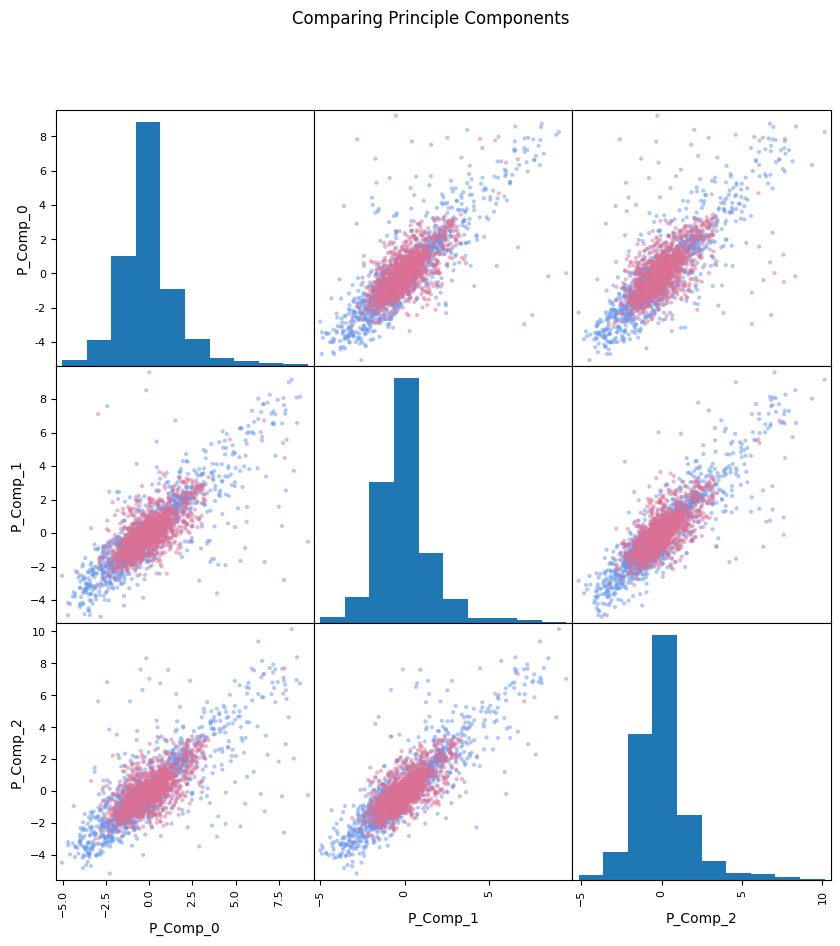

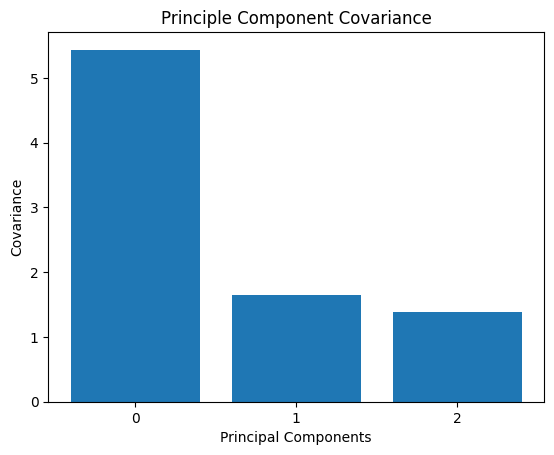

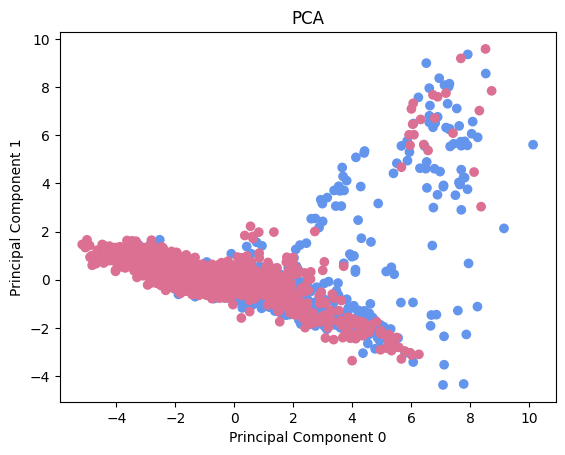

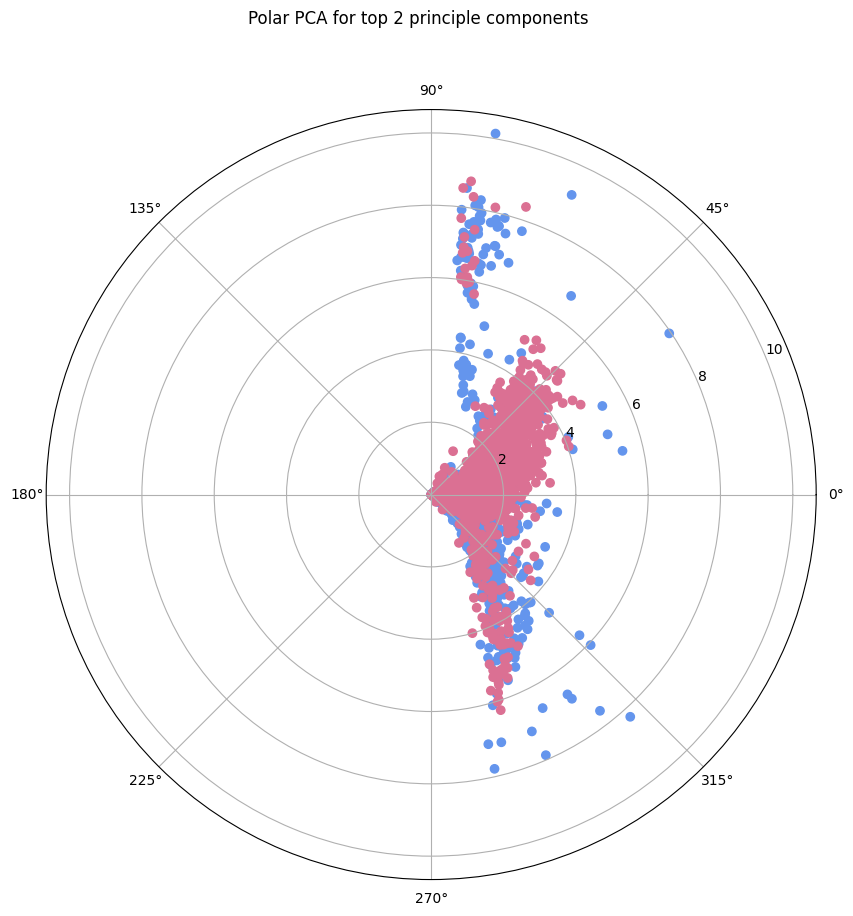

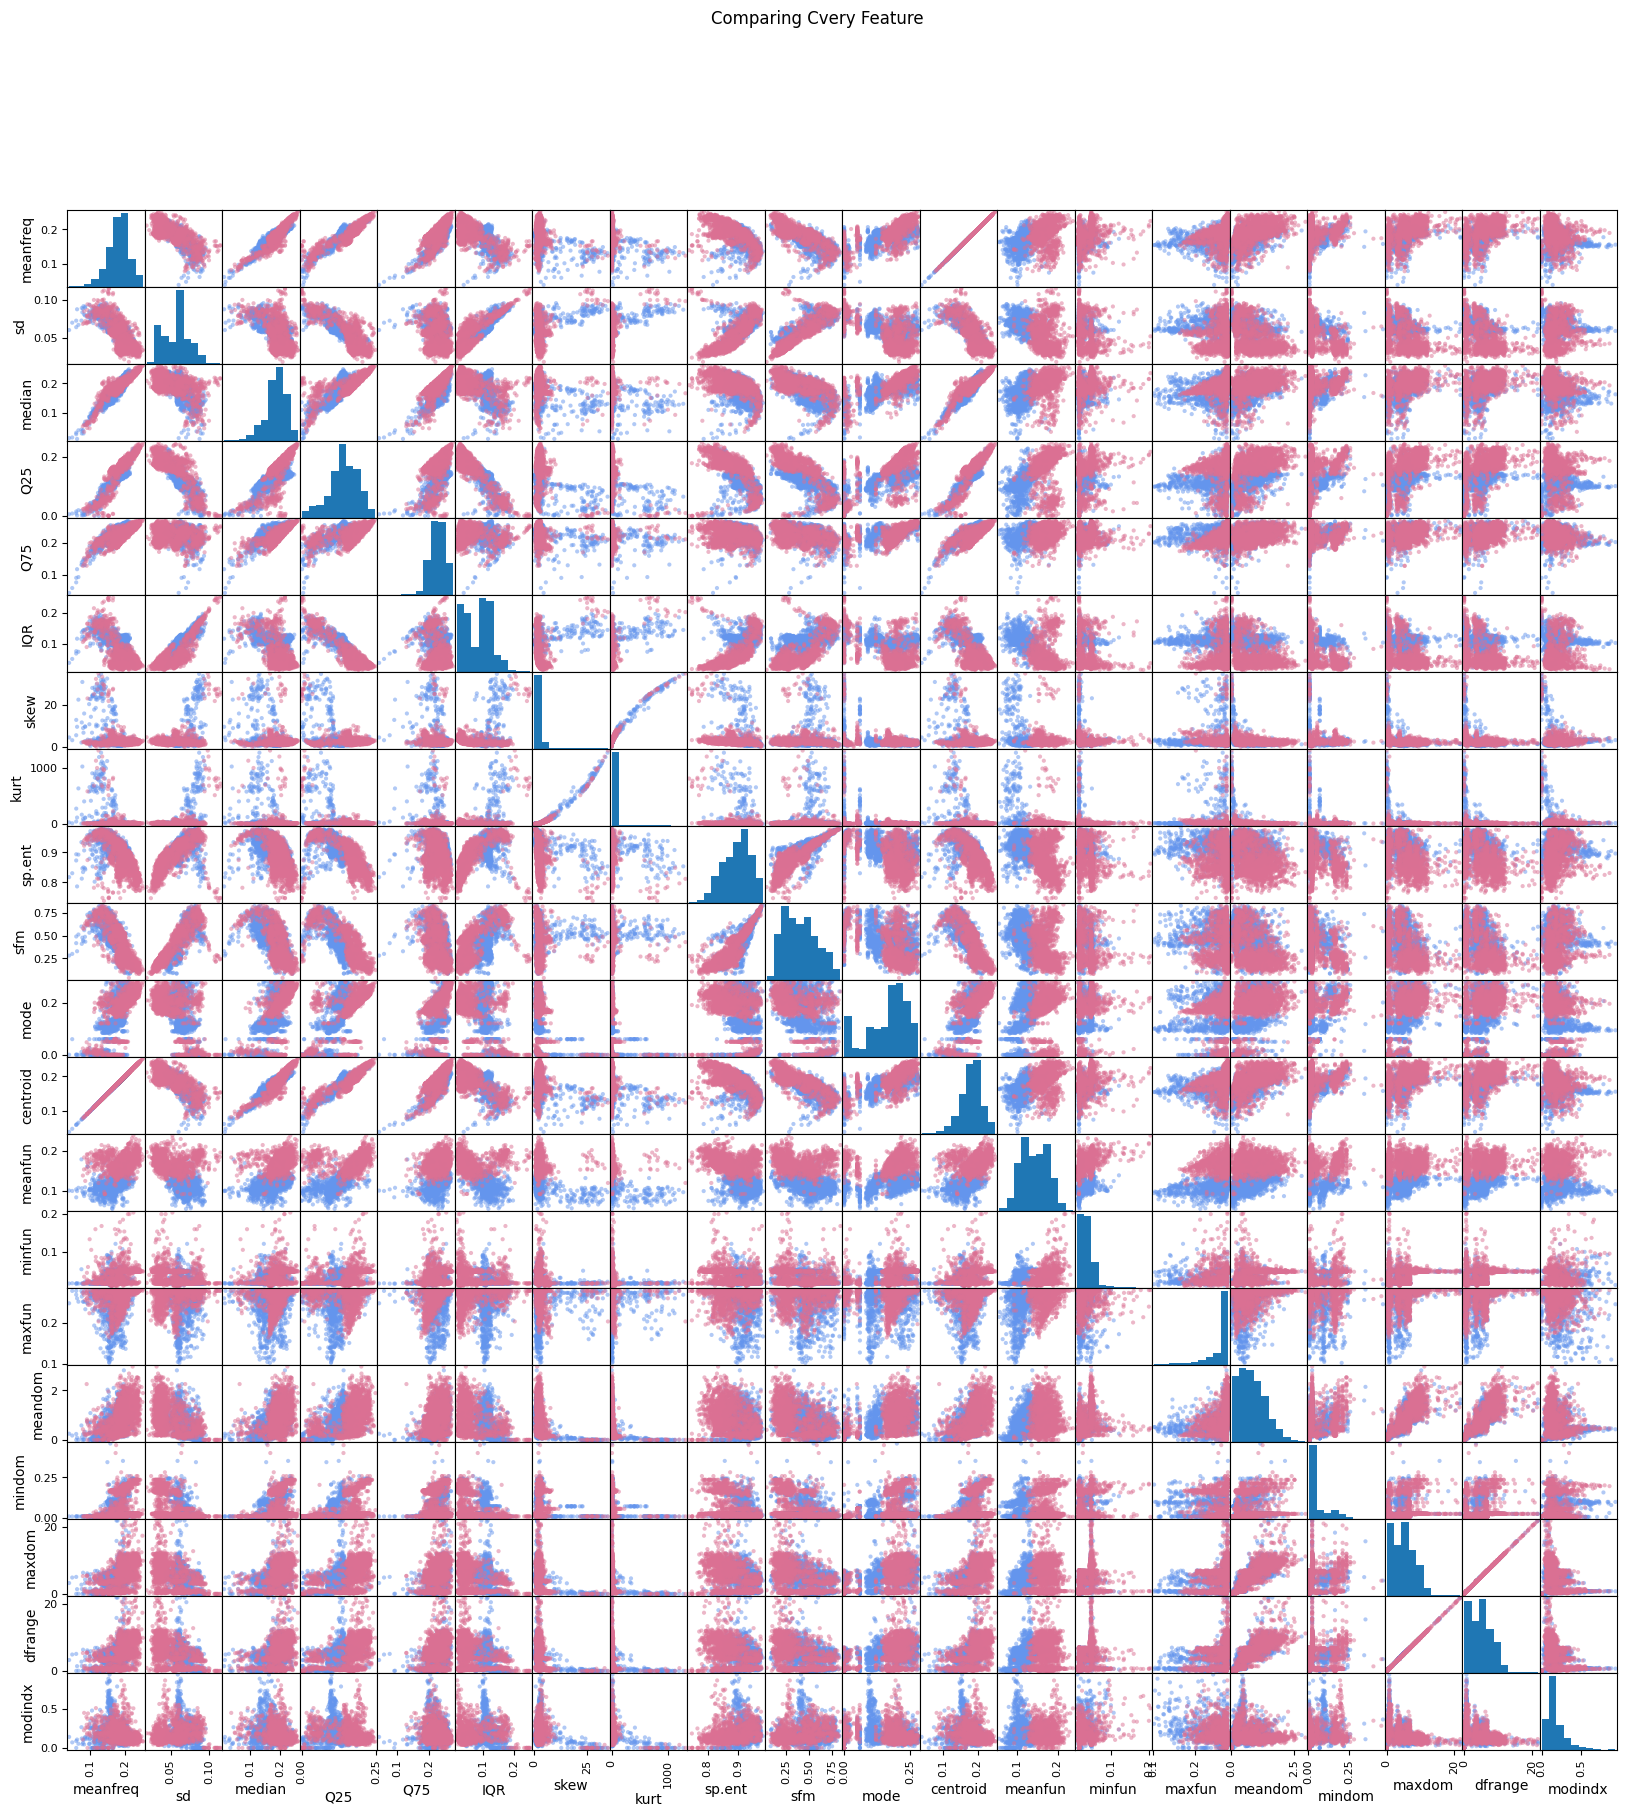

The cross validated accuracy is 94.89%


In [58]:
%run voice_gender_classification.ipynb

In [103]:
features = extract_audio_features('output.wav')
features = pd.DataFrame(features, index=[0])
print(predict(features))

['male']


In [ ]:
import numpy as np
from scipy.io import wavfile
from scipy.fft import fft

def calculate_frequencies(wav_file):
    # Read WAV file
    sample_rate, data = wavfile.read(wav_file)
    
    # Ensure audio is mono
    if len(data.shape) > 1:
        data = data.mean(axis=1)
    
    # Compute the FFT
    fft_result = fft(data)
    fft_magnitude = np.abs(fft_result)
    
    # Generate frequency bins
    freqs = np.fft.fftfreq(len(fft_result)) * sample_rate
    
    # Calculate mean frequency
    mean_frequency = np.sum(freqs * fft_magnitude) / np.sum(fft_magnitude)
    
    # Find the fundamental frequency (basic approach)
    # This simply finds the frequency with the highest magnitude in the FFT
    # For more accuracy, consider using pitch detection algorithms like YIN or CREPE
    fundamental_frequency_index = np.argmax(fft_magnitude[:len(data)//2])
    fundamental_frequency = freqs[fundamental_frequency_index]

    return mean_frequency, fundamental_frequency

# Example usage
wav_file = 'output.wav'
mean_freq, fundamental_freq = calculate_frequencies(wav_file)
print(f"Mean Frequency: {mean_freq} Hz")
print(f"Fundamental Frequency (Pitch): {fundamental_freq} Hz")